In [1]:
import numpy as np
import cv2
import os, os.path
import skimage
from  skimage.feature import hog
#import skimage.exposure

percentage = 0.8
ppc = 5 # Pixels per cell

# Construccion de base de datos
imageDir = os.getcwd()
labels = []
dic = {}

file_list = os.listdir(imageDir)
    
for folder in file_list:
    if os.path.isdir(folder) and folder[0] != '.' and len(folder) == 1: # '.ipynb_checkpoints'
        labels.append(ord(folder))
        dic[ord(folder)] = []

        for file in os.listdir(folder):
            dic[ord(folder)].append(folder + "\\" + file)

D=[] # Descriptores
L=[] # Etiquetas

# Construir dataset de entrenamiento

for label in labels:
    size = len(dic[label])
    for im in dic[label][:int(size * percentage)]:
        auxIm = cv2.imread(im, 0)
        auxIm = cv2.resize(auxIm, (20, 20))
        fd=skimage.feature.hog(auxIm, orientations = 8, pixels_per_cell = (ppc, ppc), cells_per_block = (1, 1))
        
        D.append(fd)
        L.append(label)

T=[]
LT=[]

for label in labels:
    size = len(dic[label])
    for im in dic[label][int(size * percentage):]:
        auxIm = cv2.imread(im, 0)
        auxIm = cv2.resize(auxIm, (20, 20))
        fd=hog(auxIm, orientations = 8, pixels_per_cell = (ppc, ppc), cells_per_block = (1, 1))
        
        T.append(fd)
        LT.append(label)

D = np.vstack(D)
L = np.vstack(L)

T = np.vstack(T)
LT = np.vstack(LT)

D = np.float32(D)
T = np.float32(T)

# Creamos maquina de aprendizaje
svm = cv2.ml.SVM_create()

svm.setKernel(cv2.ml.SVM_LINEAR)
svm.setType(cv2.ml.SVM_C_SVC)
svm.setC(2.67)
svm.setGamma(5.383)

svm.train(D, cv2.ml.ROW_SAMPLE, L)

result = svm.predict(T)[1]
mask = result == LT
correct = np.count_nonzero(mask)

print(correct * 100.0/ result.size)

d:\program files\python\python36\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


99.25373134328358


In [2]:
import matplotlib.pyplot as plt 
from skimage.feature import hog 
from skimage import exposure 
import numpy as np 
import cv2 
import os.path 
import imutils

def detectarPlaca(image):
    orig  = image.copy()

    # Grises
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Quitar ruido
    gray = cv2.bilateralFilter(gray, 11, 17, 17)

    # Ubicar bordes
    edged = cv2.Canny(gray, 0,255)

    # Ubicar contornos
    (new, cnts, _) = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts=sorted(cnts, key = cv2.contourArea, reverse = True)[:40] #sort contours based on their area keeping minimum required area as '30' (anything smaller than this will not be considered)
    NumberPlateCnt = None

    # Encontrar mejor parecido a placa
    count = 0
    for c in cnts:
            peri = cv2.arcLength(c, True)
            approx = cv2.approxPolyDP(c, 0.02 * peri, True)

            if len(approx) == 4:  # 4 vertices
                NumberPlateCnt = approx
                break;

    cv2.drawContours(image, [NumberPlateCnt], -1, (0,255,0), 3)

    arrX = []
    for i in range(4):
        arrX.append([NumberPlateCnt][0][i][0][0])
    arrY = []
    for i in range(4):
        arrY.append([NumberPlateCnt][0][i][0][1])

    mayorX = np.amax(arrX)
    menorX = np.amin(arrX)
    mayorY = np.amax(arrY)
    menorY = np.amin(arrY)

    image = orig[menorY:mayorY,menorX:mayorX]

    return image

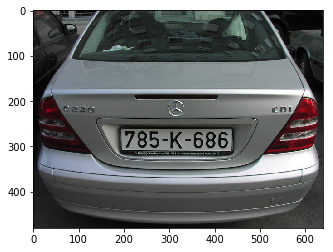

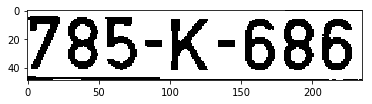

['7', '8', '5', 'K', '6', '8', '6']


d:\program files\python\python36\lib\site-packages\skimage\feature\_hog.py:150: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15. To supress this message specify explicitly the normalization method.
  skimage_deprecation)


In [8]:
from scipy.ndimage import label, generate_binary_structure
import numpy

img = cv2.imread('../070603/P6070013.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img, cmap ='gray')
plt.show()

placa =detectarPlaca(img)
placa = cv2.cvtColor(placa, cv2.COLOR_BGR2GRAY)
(thresh, im_bw) = cv2.threshold(placa, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
rows, cols = im_bw.shape
im_bw = im_bw[:, 7:cols-3]
plt.imshow(im_bw, cmap ='gray')
plt.show()

rows, cols  = im_bw.shape

_, contours, hierarchy = cv2.findContours(im_bw,cv2.RETR_CCOMP,cv2.CHAIN_APPROX_NONE)

results = []

for i in contours:
    # Find out the contour's outermost points
    izq = tuple(i[i[:,:,0].argmin()][0])[0]
    der = tuple(i[i[:,:,0].argmax()][0])[0]
    arrib = tuple(i[i[:,:,1].argmin()][0])[1]
    abj = tuple(i[i[:,:,1].argmax()][0])[1]
    
    ancho = der-izq
    alto = abj-arrib
    
    # Filtro arbitrario para descartar ruido
    if ancho > 50 or alto < 15:
        continue
    
    # Mas filtros para ruido
    character = im_bw[arrib:abj,izq:der]
    white_percentage = (np.count_nonzero(character) * 100) / (character.shape[0] * character.shape[1])
    
    if white_percentage > 80:
        continue

    #plt.subplot(1,1,1),plt.imshow(character,cmap = 'gray')
    #plt.show()
        
    character = np.ones(im_bw.shape)
    cv2.drawContours(character,i,-1,(0,255,0), 2)

    # Contour drawn over original image's size
    #plt.subplot(1,1,1),plt.imshow(character,cmap = 'gray')
    #plt.show()
    
    # Cropped plate image using contour's dimensions
    character = character[arrib:abj,izq:der]
    #plt.subplot(1,1,1),plt.imshow(character,cmap = 'gray')
    #plt.show()
    
    character = cv2.resize(character, (20, 20))
    character = hog(character, orientations = 8, pixels_per_cell = (ppc, ppc), cells_per_block = (1, 1))
    character = np.vstack([character])
    character = np.float32(character)

    resultado = svm.predict(character)[1]
    
    #print(chr(resultado))
    results.append((izq, chr(resultado)))

    mask = resultado == LT
    correct = np.count_nonzero(mask)

    #print(correct * 100.0/ resultado.size)

# Sort by left outermost point
results = sorted(results, key=lambda x: x[0])
print([i[1] for i in results])